# Market regimes prediction 市场状态预测

通过几种统计模型（如隐马尔可夫模型）和机器学习算法（如无监督机器学习技术，包括层次聚类、k 均值聚类和高斯混合模型），以确定市场状态。

In [1]:
!pip install hmmlearn

In [2]:
import numpy as np
import pandas as pd
import akshare as ak
from hmmlearn import hmm

## 获取数据
SPY：ticker symbol for the SPDR S&P 500 ETF Trust
追踪普标500指数的开放式指数基金

In [3]:
data = ak.stock_us_daily(symbol="SPY") 
data.set_index('date', inplace=True)  #时间序列数据以日期为index方便后续操作
data

,open,high,low,close,volume
date,,,,,
2001-01-02,132.00,132.1600,127.560,128.81,8732200.0
2001-01-03,128.31,136.0000,127.660,135.00,17523900.0
2001-01-04,134.94,135.4700,133.000,133.55,9095400.0
2001-01-05,133.47,133.6200,129.190,129.19,12884700.0
2001-01-08,129.88,130.1900,127.620,130.19,6552200.0
...,...,...,...,...,...
2025-10-23,668.12,672.7101,667.800,671.76,65604461.0
2025-10-24,676.46,678.4700,675.650,677.25,74356476.0
2025-10-27,682.73,685.5400,682.115,685.24,63339773.0


In [4]:
print(type(data))
data.columns

<class 'pandas.core.frame.DataFrame'>


Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

## 特征工程
daily log returns 日对数收益率
day’s range 日波动范围

In [5]:
returns = np.log(data.close / data.close.shift(1))
range = (data.high - data.low)
features = pd.concat([returns, range], axis=1).dropna()
features.columns = ["returns", "range"]

X = features
X.head()

,returns,range
date,,
2001-01-03,0.046936,8.34
2001-01-04,-0.010799,2.47
2001-01-05,-0.033192,4.43
2001-01-08,0.007711,2.57
2001-01-09,-0.002692,2.08


In [6]:
range.head()

date
2001-01-02    4.60
2001-01-03    8.34
2001-01-04    2.47
2001-01-05    4.43
2001-01-08    2.57
dtype: float64

In [7]:
returns.head()

date
2001-01-02         NaN
2001-01-03    0.046936
2001-01-04   -0.010799
2001-01-05   -0.033192
2001-01-08    0.007711
Name: close, dtype: float64

In [8]:
data.close.shift(1)

date
2001-01-02       NaN
2001-01-03    128.81
2001-01-04    135.00
2001-01-05    133.55
2001-01-08    129.19
               ...  
2025-10-23    667.80
2025-10-24    671.76
2025-10-27    677.25
2025-10-28    685.24
2025-10-29    687.06
Name: close, Length: 6243, dtype: float64

## 模型1 Markov model

## 模型训练

In [9]:
model1 = hmm.GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=15000,
)
model1.fit(X)

C:\Users\duckd\anaconda3\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,None


<Axes: >

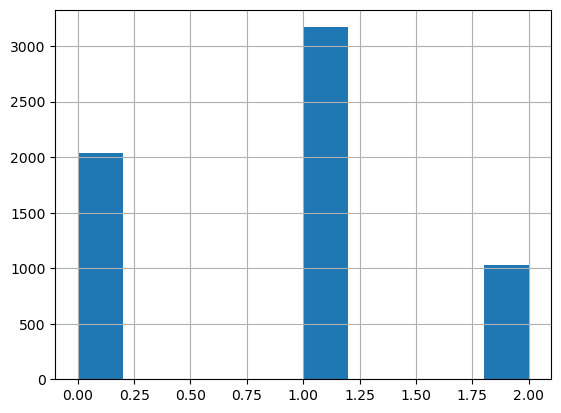

In [10]:
states = pd.Series(model1.predict(X), index=data.index[1:])
states.name = "state"
states.hist()

In [11]:
states

date
2001-01-03    2
2001-01-04    0
2001-01-05    0
2001-01-08    0
2001-01-09    0
             ..
2025-10-23    2
2025-10-24    0
2025-10-27    0
2025-10-28    0
2025-10-29    2
Name: state, Length: 6242, dtype: int64

<Axes: xlabel='date'>

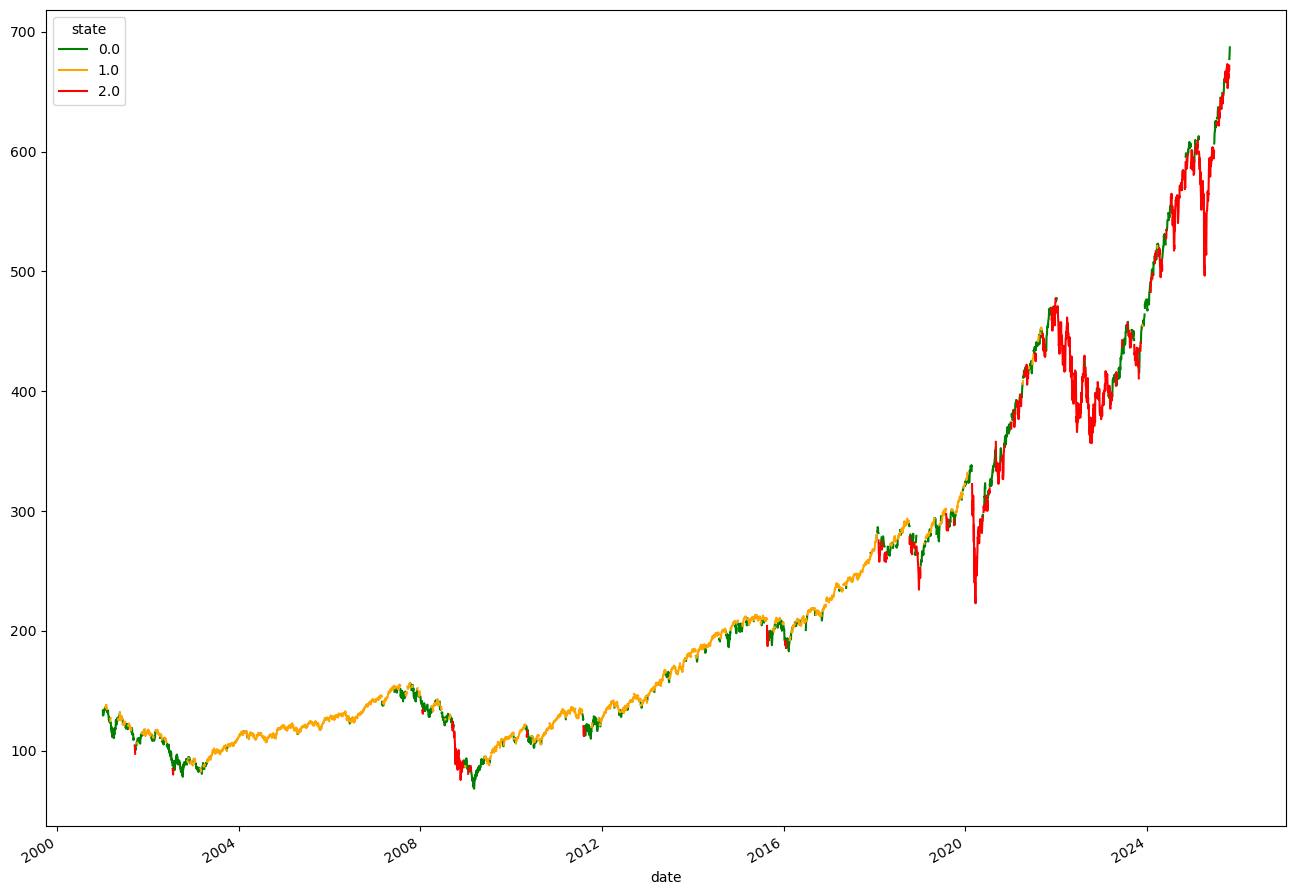

In [12]:
color_map = {
    0.0: "green",
    1.0: "orange",
    2.0: "red"
}
(
    pd.concat([data.close, states], axis=1)
    .dropna()
    .set_index("state", append=True)
    .close
    .unstack("state")
    .plot(color=color_map, figsize=[16, 12])
)


## 模型2 Gaussian mixture model 高斯混合模型

使用高斯混合模型进行聚类通常需要选择最佳模型参数，例如the number of components 
covariance constraint 协方差约束。
想象你有一个数据集，看起来它可能是由几个不同的高斯分布生成的。GMM 试图识别这些潜在分布及其参数。例如，如果你有一个包含两个簇的数据集，那么具有两个组件的 GMM 可能看起来像这样
- component：以一个聚类为中心的高斯分布。
- component：以另一个聚类为中心的高斯分布。

可以使用高斯混合模型，通过信息论准则（BIC）和赤池信息准则（AIC）进行模型选择
- sklearn.mixture.GaussianMixture 具有获取赤池信息准则（AIC）和贝叶斯信息准则（BIC）分数的内置函数

In [13]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

X = features 

X

,returns,range
date,,
2001-01-03,0.046936,8.3400
2001-01-04,-0.010799,2.4700
2001-01-05,-0.033192,4.4300
2001-01-08,0.007711,2.5700
2001-01-09,-0.002692,2.0800
...,...,...
2025-10-23,0.005912,4.9101
2025-10-24,0.008139,2.8200
2025-10-27,0.011729,3.4250


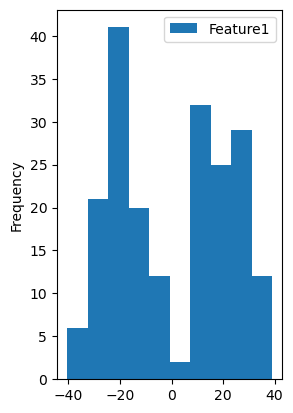

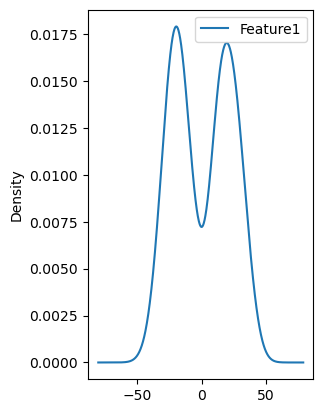

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(0)
sample_data = np.vstack([np.random.normal(loc=-20, scale=8, size=(100, 1)),
               np.random.normal(loc=20, scale=8, size=(100, 1))])

# Convert X into a DataFrame
df = pd.DataFrame(sample_data, columns=['Feature1'])

# Plot histogram of the DataFrame
df.plot(kind='hist', subplots=True, layout=(1, 2), sharex=False)
plt.show()

# Plot density plot of the DataFrame
df.plot(kind='density', subplots=True, layout=(1, 2), sharex=False)
plt.show()


In [15]:
model2 = GaussianMixture()
# only displays the changed hyper-parameters
model2

,n_components,1
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


In [16]:
from sklearn._config import get_config, set_config
set_config(print_changed_only=False)
# now we get the all hyper-parameters and their default values
model2

,n_components,1
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


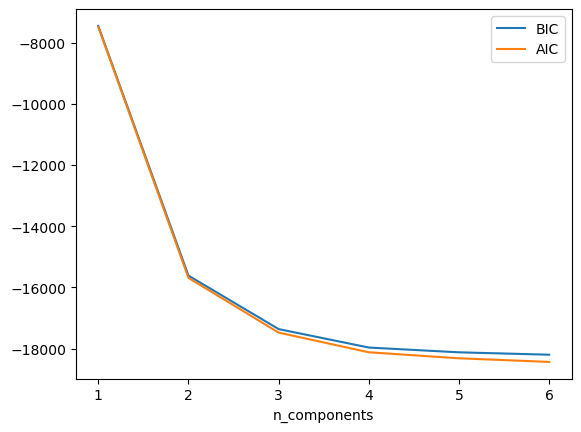

In [17]:
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');
plt.show()

根据 AIC 图，我们可以选择两个或三个状态。两个状态可能表示高波动和低波动状态；而三个状态有望解释上涨趋势、下跌趋势和横盘整理。在此处中，我们使用三个状态。

<Axes: >

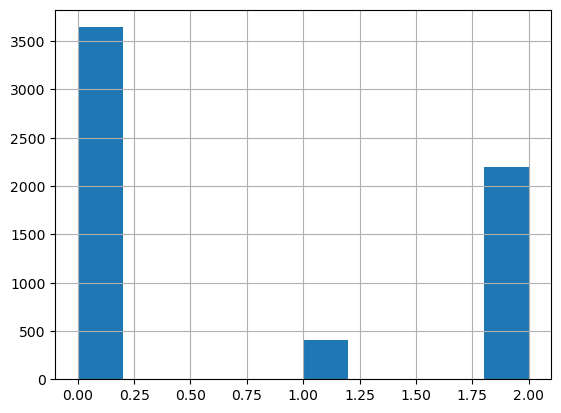

In [18]:
model2 = GaussianMixture(3, covariance_type='full', random_state=0).fit(X)
predictions = model2.predict(X)

states = pd.Series(predictions, index=data.index[1:])
states.name = "state"
states.hist()

<Axes: xlabel='date'>

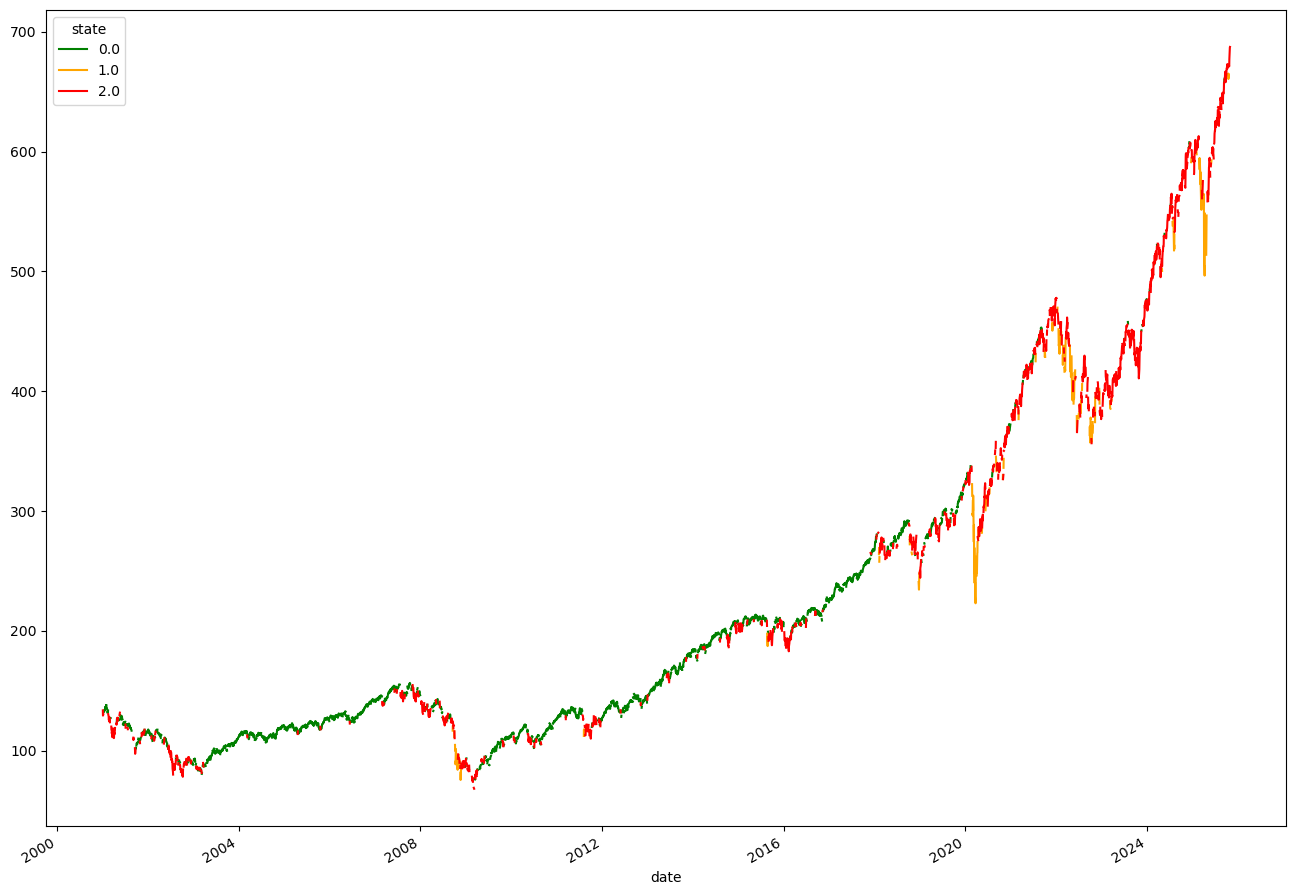

In [19]:
color_map = {
    0.0: "green",
    1.0: "orange",
    2.0: "red"
}
(
    pd.concat([data.close, states], axis=1)
    .dropna()
    .set_index("state", append=True)
    .close
    .unstack("state")
    .plot(color=color_map, figsize=[16, 12])

)

In [20]:
pd.concat([data.close, states], axis=1).head(3)

,close,state
date,,
2001-01-02,128.81,NaN
2001-01-03,135.00,1.0
2001-01-04,133.55,2.0


In [21]:
pd.concat([data.close, states], axis=1).dropna().head(3)

,close,state
date,,
2001-01-03,135.00,1.0
2001-01-04,133.55,2.0
2001-01-05,129.19,2.0


In [22]:
pd.concat([data.close, states], axis=1).dropna().set_index("state", append=True).head(3)

,,close
date,state,
2001-01-03,1.0,135.00
2001-01-04,2.0,133.55
2001-01-05,2.0,129.19


In [23]:
pd.concat([data.close, states], axis=1).dropna().set_index("state", append=True).close.unstack("state")

state,0.0,1.0,2.0
date,,,
2001-01-03,NaN,135.0,NaN
2001-01-04,NaN,NaN,133.55
2001-01-05,NaN,NaN,129.19
2001-01-08,NaN,NaN,130.19
2001-01-09,129.84,NaN,NaN
...,...,...,...
2025-10-23,NaN,NaN,671.76
2025-10-24,NaN,NaN,677.25
2025-10-27,NaN,NaN,685.24


## BIC准则调参

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs


param_grid = {
    'n_components': [2,3,4,5,6,7],
    'covariance_type': ['spherical', 'tied', 'diag', 'full']
}


def bic_scorer(fitted_gmm, X):
    return -fitted_gmm.bic(X)  # bic越低越好

grid_search  = GridSearchCV(GaussianMixture(max_iter=15000), param_grid=param_grid, scoring=bic_scorer)
grid_search .fit(X)
grid_search .best_score_, grid_search.best_params_

(np.float64(2849.6518924876664),
 {'covariance_type': 'diag', 'n_components': 5})

## Hyper-parameter search 超参数搜索

[0 1 2 3 4]


<Axes: xlabel='date'>

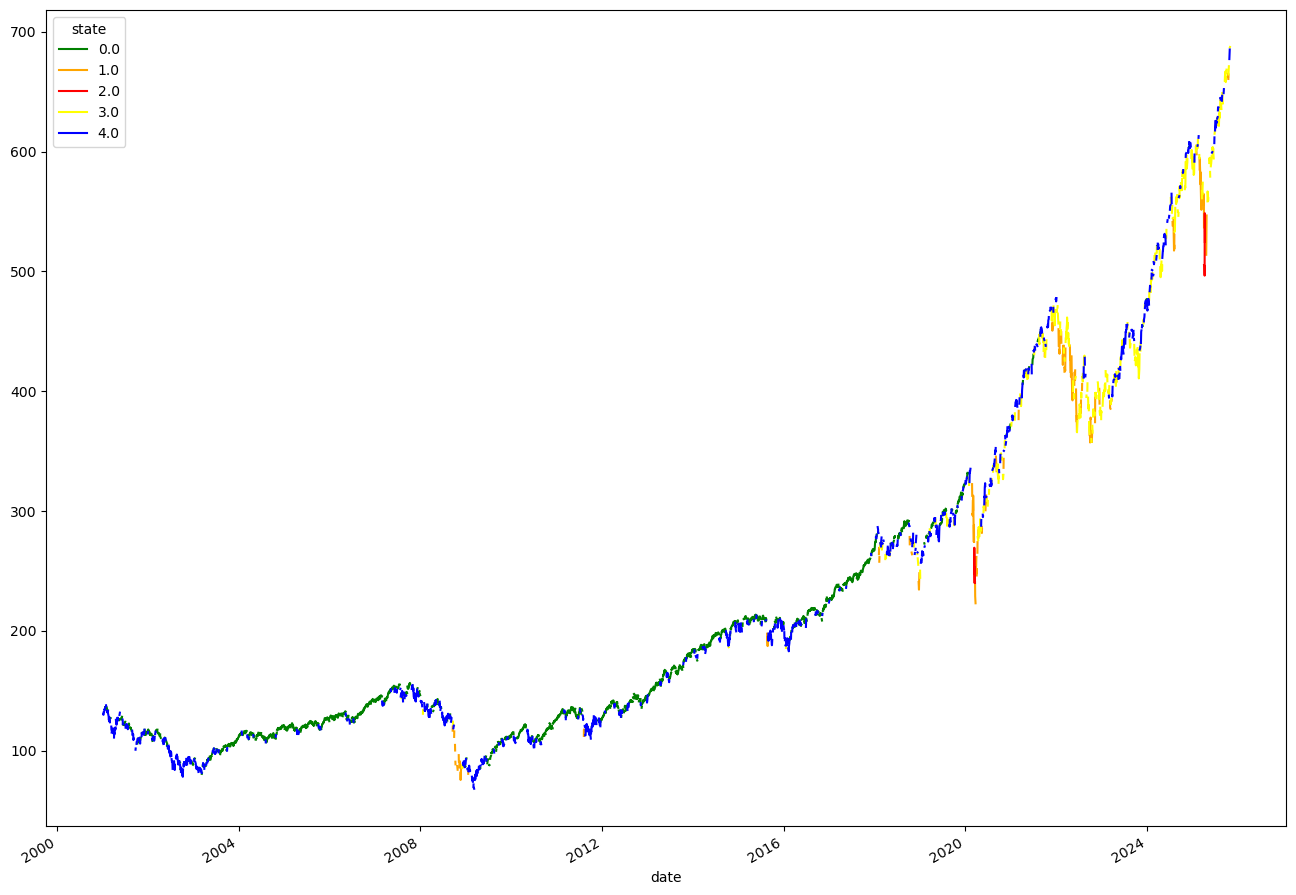

In [25]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X)

states = pd.Series(predictions, index=data.index[1:])
states.name = "state"

print(np.unique(predictions))

color_map = {
    0.0: "green",
    1.0: "orange",
    2.0: "red",
    3.0: "yellow",
    4.0: "blue",
    5.0: "purple"
}
(
    pd.concat([data.close, states], axis=1)
    .dropna()
    .set_index("state", append=True)
    .close
    .unstack("state")
    .plot(color=color_map, figsize=[16, 12])
    
)

在股票状态分析中，使用**聚类技术**通常侧重于发现时间序列数据中的现有模式，而非预测未来值

## Agglomerative Clustering model 凝聚层次聚类模型

sklearn.cluster.AgglomerativeClustering 对象没有 'predict' 方法，用 model.labels_ 属性或 model.fit_predict(X) 来代替 predict 方法

In [26]:
from sklearn.cluster import AgglomerativeClustering
model3 = AgglomerativeClustering(n_clusters =3).fit(X) 
model3

,n_clusters,3
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,None
,compute_distances,False


<Axes: >

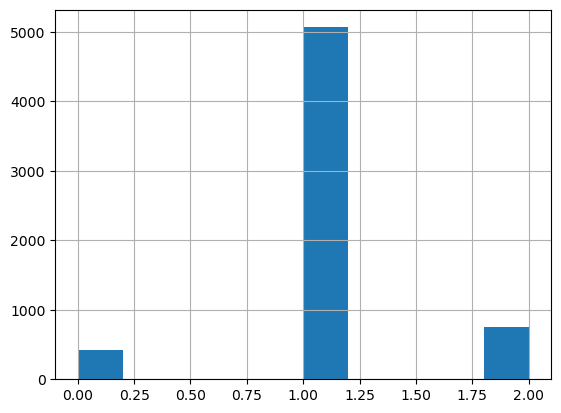

In [27]:
states = pd.Series(model3.labels_, index=data.index[1:])
states.name = "state"
states.hist()

<Axes: >

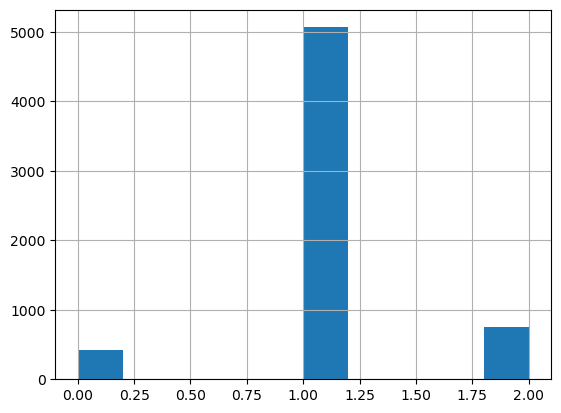

In [28]:
states = pd.Series(model3.fit_predict(X), index=data.index[1:])
states.name = "state"
states.hist()

<Axes: xlabel='date'>

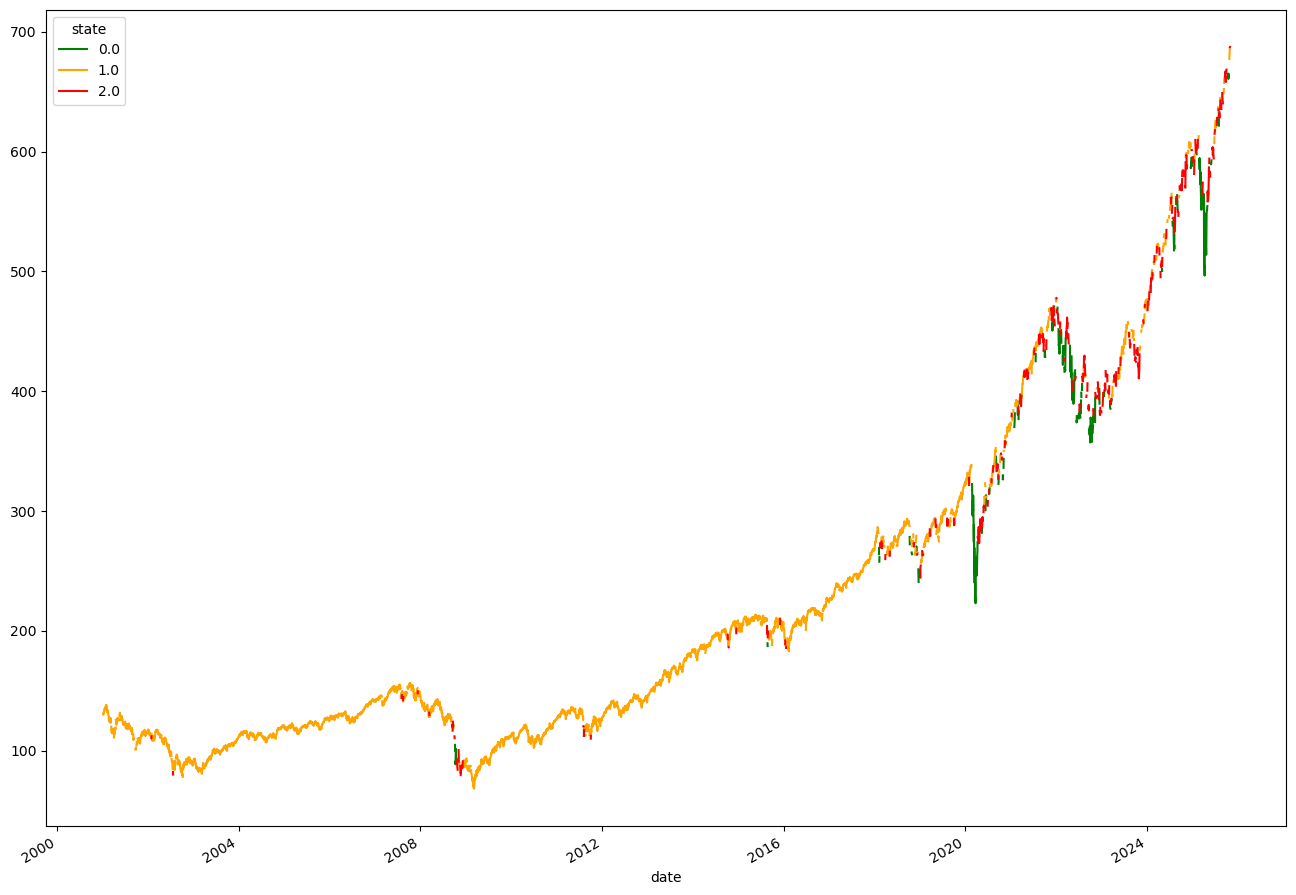

In [29]:
color_map = {
    0.0: "green",
    1.0: "orange",
    2.0: "red"
}
(
    pd.concat([data.close, states], axis=1)
    .dropna()
    .set_index("state", append=True)
    .close
    .unstack("state")
    .plot(color=color_map, figsize=[16, 12])
)

## K means model 

有一种名为 K-Means++的算法，可用于为 K-Means 选择初始值或初始聚类质心

In [30]:
from sklearn.cluster import KMeans

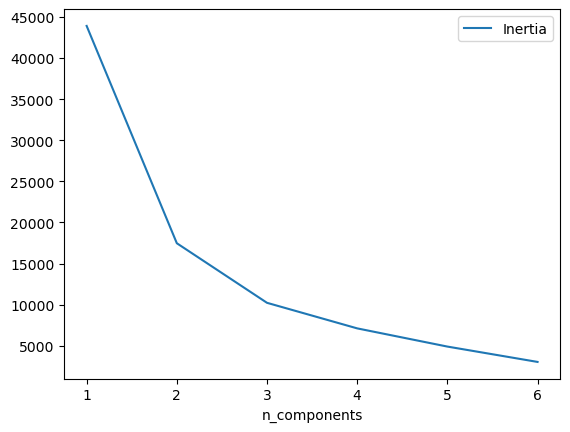

In [31]:
n_clusters = np.arange(1, 7)
models = [KMeans(n, init='k-means++').fit(X) for n in n_clusters]

plt.plot(n_clusters, [m.inertia_ for m in models], label='Inertia')

plt.legend(loc='best')
plt.xlabel('n_components');
#plt.show()

In [32]:
model4 = KMeans(3, init='k-means++').fit(X)
model4

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


<Axes: >

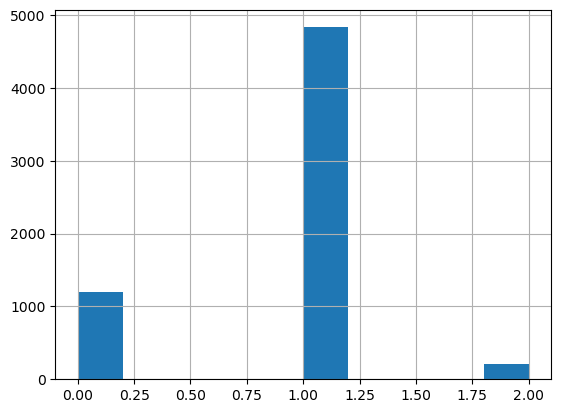

In [33]:
states = pd.Series(model4.predict(X), index=data.index[1:])
states.name = "state"
states.hist()

<Axes: xlabel='date'>

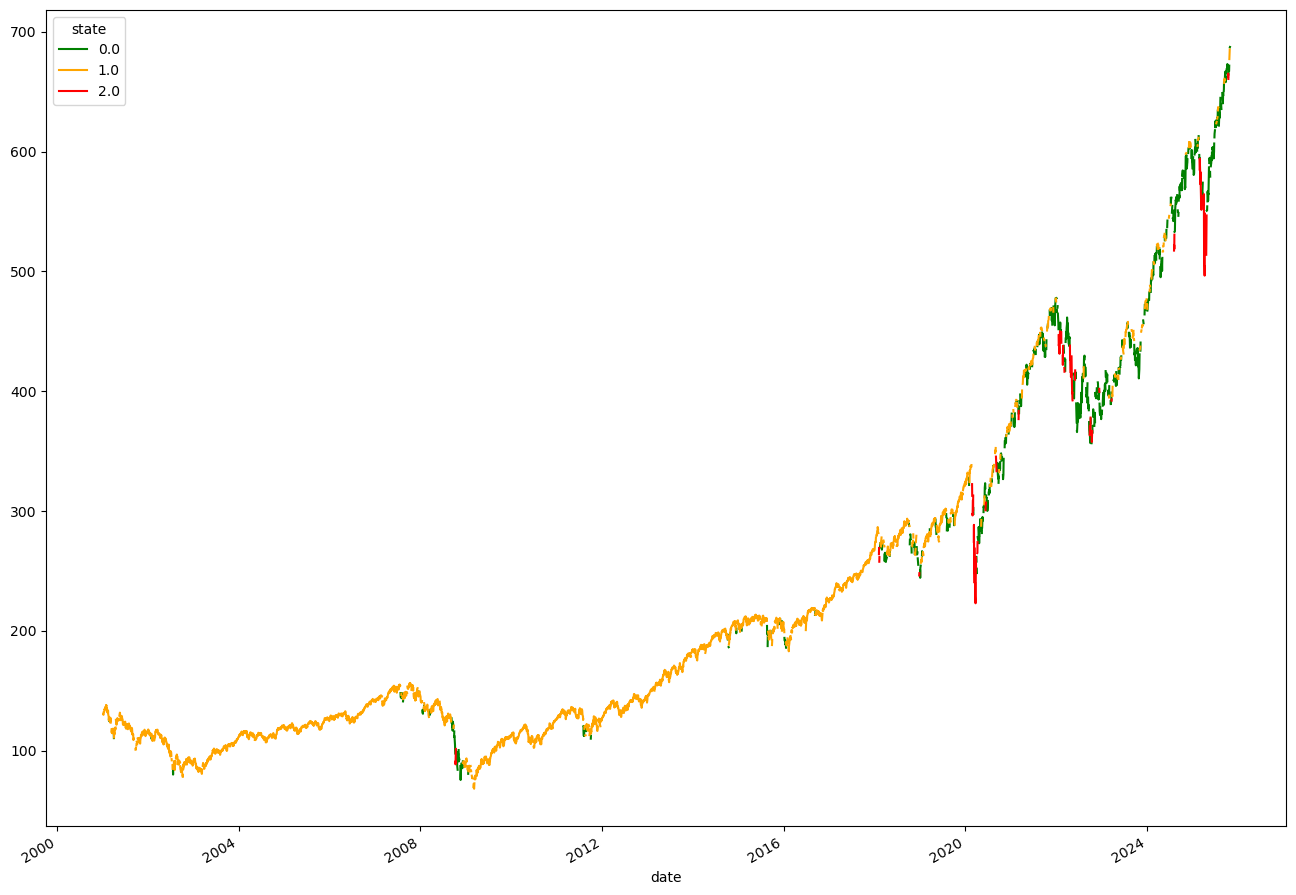

In [34]:
color_map = {
    0.0: "green",
    1.0: "orange",
    2.0: "red"
}
(
    pd.concat([data.close, states], axis=1)
    .dropna()
    .set_index("state", append=True)
    .close
    .unstack("state")
    .plot(color=color_map, figsize=[16, 12])
)

## 标准化

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<Axes: xlabel='date'>

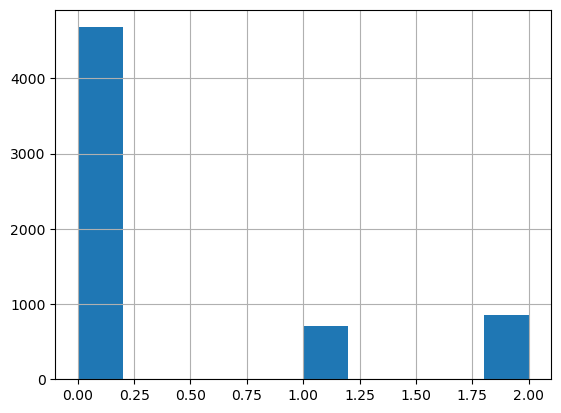

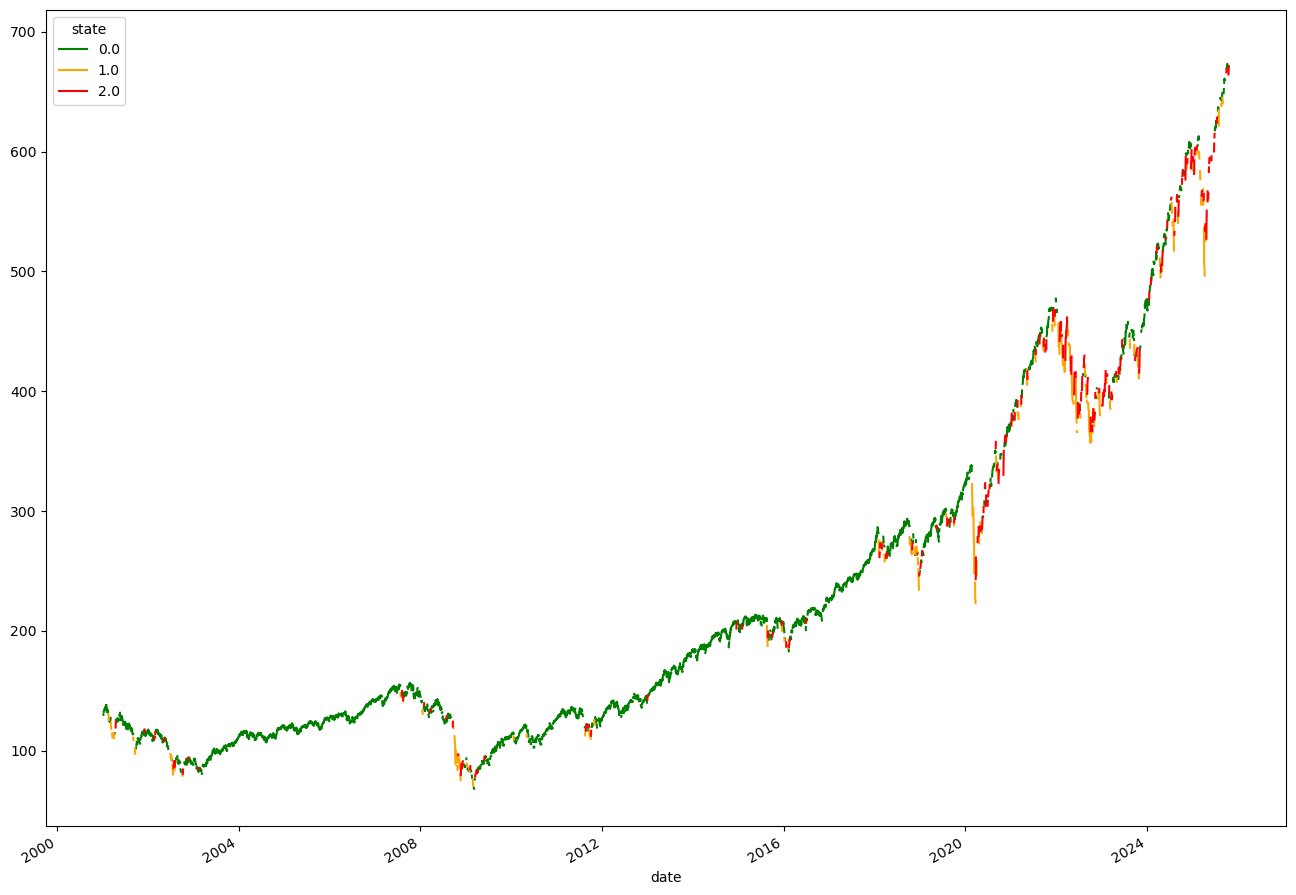

In [36]:
model5 = KMeans(3, init='k-means++').fit(X_scaled)
states = pd.Series(model5.predict(X_scaled), index=data.index[1:])
states.name = "state"
states.hist()
color_map = {
    0.0: "green",
    1.0: "orange",
    2.0: "red"
}
(
    pd.concat([data.close, states], axis=1)
    .dropna()
    .set_index("state", append=True)
    .close
    .unstack("state")
    .plot(color=color_map, figsize=[16, 12])
)